In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


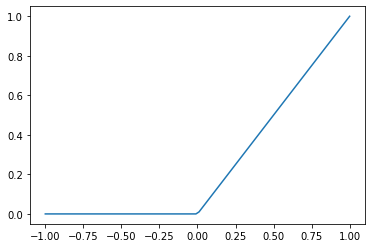

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

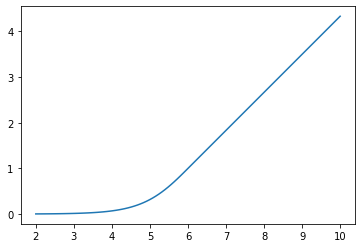

In [5]:
def area_coef(x:Tensor, targ:float) -> Tensor:
    d = 10*(x - targ)/targ
    m = d > 0
    c = 2*torch.sigmoid(d)
    c[m] = 1+(d[m]/2)
    return c

x = torch.linspace(2, 10)
plt.plot(x, area_coef(x, 6))

In [6]:
from typing import *

class DetectorLoss(nn.Module):
    def __init__(
        self,
        *,
        target_budget: float,
        budget_smoothing: float = 10,
        cost_coef: Optional[Union[Tensor, float]] = None,
        debug: bool = False,
    ):
        super().__init__()
        self.target_budget, self.budget_smoothing, self.cost_coef, self.debug = target_budget, budget_smoothing, cost_coef, debug
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry
        
    def _get_budget_coef(self, cost: Tensor) -> Union[Tensor, float]:
        r'''Switch-on near target budget, plus linear increase above budget'''
        if self.target_budget is None: return 0
        d = self.budget_smoothing*(cost-self.target_budget)/self.target_budget
        if d <= 0:
            return 2*torch.sigmoid(d)
        else:
            return 1+(d/2)

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach().clone()
        print(f"Automatically setting cost coefficient to {self.cost_coef}")

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        self.sub_losses = {}
        true_x0 = volume.get_rad_cube()
        inference = torch.mean((pred_x0 - true_x0).pow(2) / pred_weight)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self._get_budget_coef(cost) * self.cost_coef
        if self.debug:
            print(
                f'cost {cost}, cost coef {self.cost_coef}, budget coef {self._get_budget_coef(cost)}. error loss {self.sub_losses["error"]}, cost loss {self.sub_losses["cost"]}'
            )
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [7]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [8]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

In [9]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

In [10]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=DetectorLoss(target_budget=0.8, cost_coef=2.1811e-06, debug=True))  # Loss is precision + budget_coef*cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

In [11]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [12]:
passives = PassiveYielder([arb_rad_length])

In [13]:
from tomopt.optimisation.callbacks.callback import Callback

class CostCoefWarmup(Callback):
    def __init__(self, n_warmup:int):
        self.n_warmup = n_warmup
        
    def on_train_begin(self)-> None:
        super().on_train_begin()
        self.e_sum = torch.zeros(1, device=self.wrapper.device)
        self.epoch_cnt = 0
        self.tracking = True
        self.lrs = {}
        for o in self.wrapper.opts:  # Prevent updates during warmup (can't freeze due to grad in inference)
            self.lrs[o] = self.wrapper.get_opt_lr(o)
            self.wrapper.set_opt_lr(0.0, o)
            
        
    def on_epoch_begin(self) -> None:
        self.v_sum = torch.zeros(1, device=self.wrapper.device)
        self.volume_cnt = 0
            
    def on_volume_end(self) -> None:
        if self.tracking and self.wrapper.fit_params.state == 'train' and self.wrapper.fit_params.pred is not None:
            self.v_sum += self.wrapper.loss_func.sub_losses['error'].detach().clone()
            self.volume_cnt += 1
            
    def on_epoch_end(self) -> None:
        if self.tracking and self.wrapper.fit_params.state == 'train':
            self.e_sum += self.v_sum/self.volume_cnt
            self.epoch_cnt += 1
            if self.epoch_cnt == self.n_warmup:
                avg = self.e_sum/self.epoch_cnt
                print(f'Warmed up, average error = {avg}')
                self.wrapper.loss_func.cost_coef = avg
                self.tracking = False
                for o in self.wrapper.opts:  # Allow optimisation
                    self.wrapper.set_opt_lr(self.lrs[o], o)

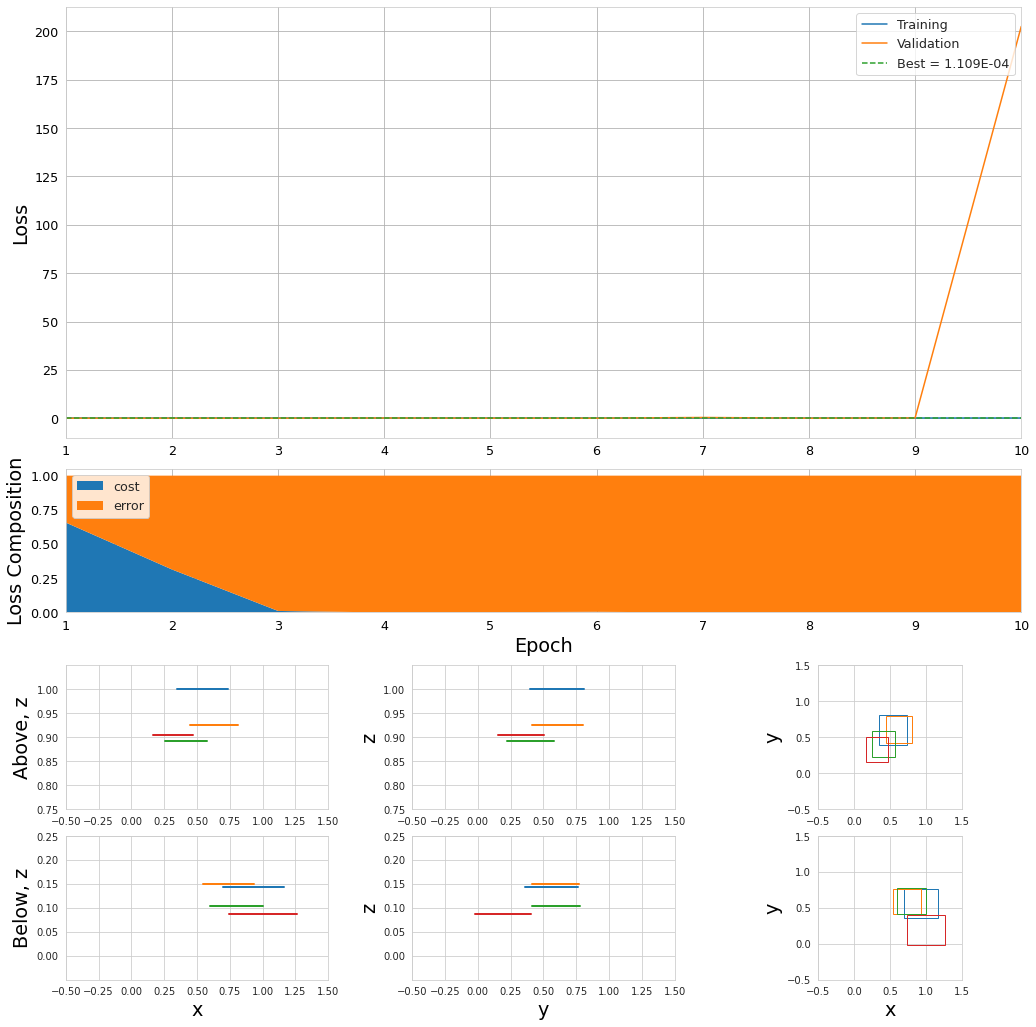

cost 8.0, cost coef 2.1811e-06, budget coef 46.0. error loss 1.738553578434221e-06, cost loss 0.00010033059515990317
cost 5.988306999206543, cost coef 2.1811e-06, budget coef 33.426918029785156. error loss 3.7999823689460754e-05, cost loss 7.290744542842731e-05


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:212: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


cost 5.988306999206543, cost coef 2.1811e-06, budget coef 33.426918029785156. error loss 1.3803935416945023e-06, cost loss 7.290744542842731e-05
cost 4.4905171394348145, cost coef 2.1811e-06, budget coef 24.065731048583984. error loss 0.00011437198554631323, cost loss 5.24897659488488e-05
cost 4.4905171394348145, cost coef 2.1811e-06, budget coef 24.065731048583984. error loss 3.080839974245464e-07, cost loss 5.24897659488488e-05
cost 3.3531575202941895, cost coef 2.1811e-06, budget coef 16.95723533630371. error loss 0.0033020712435245514, cost loss 3.698542423080653e-05
cost 3.3531575202941895, cost coef 2.1811e-06, budget coef 16.95723533630371. error loss 1.1638074965958367e-06, cost loss 3.698542423080653e-05
cost 2.5353658199310303, cost coef 2.1811e-06, budget coef 11.846036911010742. error loss 0.10540055483579636, cost loss 2.5837391149252653e-05
cost 2.5353658199310303, cost coef 2.1811e-06, budget coef 11.846036911010742. error loss 3.41076685117514e-07, cost loss 2.583739114

<Figure size 1024x1024 with 0 Axes>

In [14]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[PanelMetricLogger()])

In [15]:
for p in volume.parameters(): print(p)

Parameter containing:
tensor([0.5416, 0.6013], requires_grad=True)
Parameter containing:
tensor([0.9999], requires_grad=True)
Parameter containing:
tensor([0.3871, 0.4109], requires_grad=True)
Parameter containing:
tensor([0.6282, 0.6068], requires_grad=True)
Parameter containing:
tensor([0.9259], requires_grad=True)
Parameter containing:
tensor([0.3660, 0.3829], requires_grad=True)
Parameter containing:
tensor([0.4129, 0.4039], requires_grad=True)
Parameter containing:
tensor([0.8914], requires_grad=True)
Parameter containing:
tensor([0.3196, 0.3596], requires_grad=True)
Parameter containing:
tensor([0.3160, 0.3302], requires_grad=True)
Parameter containing:
tensor([0.9050], requires_grad=True)
Parameter containing:
tensor([0.3086, 0.3520], requires_grad=True)
Parameter containing:
tensor([0.9318, 0.5614], requires_grad=True)
Parameter containing:
tensor([0.1442], requires_grad=True)
Parameter containing:
tensor([0.4621, 0.4012], requires_grad=True)
Parameter containing:
tensor([0.741